# Inference on big images

1) [Splitting with info](#splitting-with-info) \
2) [Sliding window + overlapp](#sliding-window--overlap) \
    2.1) [Prepare tiles](#prepare-tiles) \
    2.2) [Predictions on tiles](#predictions-on-tiles) \
    2.3) [Labels generation](#labels-generation) \
    2.4) [Saving final masks](#saving-final-mask)
3) [Multi-resolution inference](#multi-resolution-inference) \
    3.1) [Predictions making](#predictions-making) \
    3.2) [Predictions at different resolutions](#predictions-at-different-resolutions) \
    3.3) [Merge different resolutions into one](#merge-different-resolutions-into-one) \
    3.4) [Show prob heatmap](#show-prob-heatmap)

## Dependencies

In [25]:
import os
import sys
import shutil
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from omegaconf import OmegaConf
import torch

### splitting with info

In [3]:
def tile_image_overlap(in_path, tile_size=512, overlap=0, save_dir="default", verbose=False):
    save_dir = os.path.join(os.path.dirname(in_path), 'tiles') if save_dir == "default" else save_dir
    os.makedirs(save_dir, exist_ok=True)

    img = Image.open(in_path)
    w, h = img.size

    tiles = []
    tile_id = 0
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            # manage if borders reached
            x0 = min(x, w - tile_size)
            y0 = min(y, h - tile_size)

            # Crop region (handles border tiles automatically)
            tile = img.crop((x0, y0, x0 + tile_size, y0 + tile_size))
            name = os.path.splitext(os.path.basename(in_path))[0] + f"_{tile_id}.tif"
            tile.save(os.path.join(save_dir, name))
            
            tiles.append({
                "tile_id": tile_id,
                "x": x0,
                "y": y0,
                "path": name
            })

            tile_id += 1
    if verbose:
        print(f"Saved {tile_id} overlapping tiles.")
    return tiles

In [9]:
src_dir = r"D:\Terranum_SD\99_Data\Landslide\data\Bern_glissements_spontane_shpfiles\test_reconstruct"
num_samples = 0
tile_size = 512
results = {"samples_pos": []}

list_images_to_process = [os.path.join(src_dir, x) for x in os.listdir(src_dir) if 'image' in x and os.path.splitext(x)[1].lower() in ['.jpg','.jpeg','.png','.tif']]
# temp_list = [os.path.join(src_data, x) for x in os.listdir(src_data) if x.endswith('tif')]
for _ ,image in tqdm(enumerate(list_images_to_process), total=len(list_images_to_process)):
    sub_results = tile_image_overlap(image, tile_size=tile_size)
    num_samples += len(sub_results)
    results['samples_pos'].append(sub_results)

print("Number of created tiles: ", num_samples)

results['samples_pos'] = [x for row in results['samples_pos'] for x in row]

results['tile_size'] = tile_size
results['num_samples'] = num_samples

with open(os.path.join(src_dir, 'tiles', 'images_metadata.json'), 'w') as f:
    json.dump(results, f, indent=2)

100%|██████████| 449/449 [00:26<00:00, 16.93it/s]

Number of created tiles:  4685


In [ ]:
src_dir = r"D:\Terranum_SD\99_Data\Landslide\data\Bern_glissements_spontane_shpfiles\test_reconstruct"
num_samples = 0
tile_size = 512
results = {"samples_pos": []}

list_images_to_process = [os.path.join(src_dir, x) for x in os.listdir(src_dir) if 'mask' in x and os.path.splitext(x)[1].lower() in ['.jpg','.jpeg','.png','.tif']]
# temp_list = [os.path.join(src_data, x) for x in os.listdir(src_data) if x.endswith('tif')]
for _ ,image in tqdm(enumerate(list_images_to_process), total=len(list_images_to_process)):
    sub_results = tile_image_overlap(image, tile_size=tile_size)
    num_samples += len(sub_results)
    results['samples_pos'].append(sub_results)

print("Number of created tiles: ", num_samples)

results['samples_pos'] = [x for row in results['samples_pos'] for x in row]

results['tile_size'] = tile_size
results['num_samples'] = num_samples

with open(os.path.join(src_dir, 'tiles', 'masks_metadata.json'), 'w') as f:
    json.dump(results, f, indent=2)

100%|██████████| 449/449 [00:08<00:00, 52.39it/s]

Number of created tiles:  4685


### Sliding window + overlap

In [25]:
src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_sliding_window\2015_104\image_2015_104.png"
src_dest = os.path.join(os.path.dirname(src_img), 'tiles')

TILE_SIZE = 512
STRIDE = 256

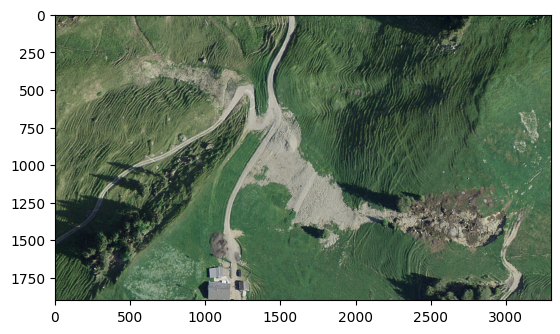

In [26]:
img = Image.open(src_img)
img_arr = np.array(img)
plt.imshow(img_arr)

#### Prepare tiles

In [27]:
def mirror_pad_image(img, tile_size, stride):
    """
    img: (H, W, C)
    """
    H, W = img.shape[:2]

    pad_h = (stride - (H - tile_size) % stride) % stride
    pad_w = (stride - (W - tile_size) % stride) % stride

    padded = np.pad(
        img,
        ((0, pad_h),
         (0, pad_w),
         (0, 0)),
        mode="reflect"
    )

    return padded, (pad_h, pad_w), (H, W)


def split_with_overlap(src_img_in, src_output, tile_size=512, stride=256):
    os.makedirs(src_output, exist_ok=True)
    img = Image.open(src_img_in)
    img_arr = np.array(img)

    img_padded, _, _ = mirror_pad_image(img_arr, tile_size, stride)
    H_original, W_original  = img_arr.shape[:2]
    H, W = img_padded.shape[:2]
    tiles = []
    tile_id = 0
    for x in range(0, W - tile_size + 1, stride):# manage if borders reached
        for y in range(0, H - tile_size + 1, stride):
            x0 = min(x, W - tile_size)
            y0 = min(y, H - tile_size)

            # Crop region (handles border tiles automatically)
            tile = img_padded[y0:y0 + tile_size, x0:x0 + tile_size, :]
            name = os.path.splitext(os.path.basename(src_img_in))[0] + f"_{tile_id}.tif"
            Image.fromarray(tile).save(os.path.join(src_output, name))
            
            tiles.append({
                "tile_id": tile_id,
                "x": x0,
                "y": y0,
                "path": name
            })

            tile_id += 1
    return tiles, (H_original, W_original), (H,W)

# tiles_info, dim_original, dim_pad = split_with_overlap(src_img, src_dest, TILE_SIZE, STRIDE)

In [28]:
tiles_info, dim_original, dim_pad = split_with_overlap(src_img, src_dest, TILE_SIZE, STRIDE)
results = {
    "img_src": src_img,
    "tile_size": TILE_SIZE,
    "stride": STRIDE,
    "dim_original": dim_original,
    "dim_padded": dim_pad,
    "samples_pos": tiles_info,
    }

print("Number of created tiles: ", len(tiles_info))

with open(os.path.join(src_dest, 'masks_metadata.json'), 'w') as f:
    json.dump(results, f, indent=2)

Number of created tiles:  84


#### Predictions on tiles

In [29]:
if not os.path.dirname(os.getcwd()) in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))

In [30]:
from inference import run_inference, predict_image
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

In [31]:
def load_latest_checkpoint(model_dir):
    """
    Returns the path to the latest checkpoint folder inside model_dir.
    If none found, return model_dir (trained_model directory).
    """
    if not os.path.isdir(model_dir):
        raise ValueError(f"Model directory not found: {model_dir}")

    ckpts = [d for d in os.listdir(model_dir) if d.startswith("checkpoint-")]
    if not ckpts:
        print("[INFO] No checkpoints found. Using main model directory.")
        return model_dir

    # Sort by step number
    ckpts_sorted = sorted(ckpts, key=lambda x: int(x.split("-")[1]))
    last_ckpt = ckpts_sorted[-1]

    print(f"[INFO] Using checkpoint: {last_ckpt}")
    return os.path.join(model_dir, last_ckpt)


def gaussian_weight(size, sigma=0.125):
    ax = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(ax, ax)
    return np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

In [32]:
# MODEL_DIR = "../results/training/20251218_164631_50_epochs_Longxi_da_weighted_dice_loss"
MODEL_DIR = "../results/training/20251217_155250_50_epochs_Bern_v2_da_splitsets"

SAVE_MASK_AS_IMG = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [40]:
# load json
with open(os.path.join(src_dest, 'masks_metadata.json'), 'r') as f:
    metadata = json.load(f)
dim_original = metadata['dim_original']
dim_padded = metadata['dim_padded']
pad_y, pad_x = [a - b for a,b in zip(dim_padded, dim_original)]
tiles_infos = metadata['samples_pos']
tile_size = metadata['tile_size']
stride = metadata['stride']

# prepare arrays
prob_acc = np.zeros(dim_padded, dtype=np.float32)
weight_acc = np.zeros(dim_padded, dtype=np.float32)
weights = gaussian_weight(tile_size)

# load model
ckpt_path = load_latest_checkpoint(MODEL_DIR)
processor = AutoImageProcessor.from_pretrained(ckpt_path)
model = SegformerForSemanticSegmentation.from_pretrained(ckpt_path)
model.to(DEVICE)
model.eval()

# predict
for cp, tile in tqdm(enumerate(tiles_infos), total=len(tiles_infos)):
    tile_id = tile["tile_id"]
    x = tile["x"]
    y = tile["y"]
    name = tile["path"]
    _, logits  = predict_image(model, processor, os.path.join(src_dest, name), DEVICE)

    prob = torch.softmax(logits, dim=1).cpu().numpy()
    landslide_prob = prob[:, 1].reshape((TILE_SIZE, TILE_SIZE))


    # prob_acc[y:y+tile_size, x:x+tile_size] += landslide_prob * weights
    # weight_acc[y:y+tile_size, x:x+tile_size] += weights
    prob_acc[y:y+tile_size, x:x+tile_size] += landslide_prob
    weight_acc[y:y+tile_size, x:x+tile_size] += 1

full_prob = prob_acc / np.maximum(weight_acc, 1e-6)
final_prob = full_prob[0:dim_original[0], 0:dim_original[1]]


[INFO] Using checkpoint: checkpoint-20300


100%|██████████| 84/84 [00:01<00:00, 53.11it/s]


In [41]:
print(np.sum(final_prob) / final_prob.size)

0.069630586


#### Labels generation

402966.0
0.0642688995215311
(1900, 3300)


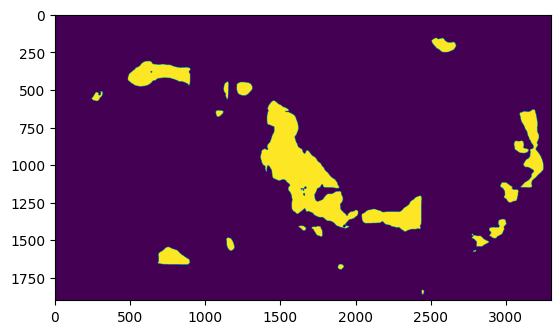

In [42]:
threshold = 0.5
final_labels = np.zeros(final_prob.shape)
final_labels[final_prob >= threshold] = 1
print(np.sum(final_labels))
print(np.sum(final_labels) / final_labels.size)
print(final_labels.shape)

plt.imshow(final_labels)

#### Saving final mask

In [ ]:
src_dest_preds_mask = os.path.splitext(src_img)[0] + '_preds_mask.tif'
src_dest_preds_img = os.path.splitext(src_img)[0] + '_preds_img.tif'

Image.fromarray(final_labels.astype(np.uint8)).save(src_dest_preds_mask)
if SAVE_MASK_AS_IMG:
    rgb_mask = np.zeros((final_labels.shape[0], final_labels.shape[1], 3))
    rgb_mask[final_labels == 1] = 255
    Image.fromarray(rgb_mask.astype(np.uint8)).save(src_dest_preds_img)

### Multi-resolution inference

In [2]:
src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\1999_56\image_1999_56.png"
# src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\swissimage-dop10_2018_2603-1184_0.1_2056\swissimage-dop10_2018_2603-1184_0.1_2056.tif"
# src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\swissimage-dop10_2018_2598-1175_0.1_2056\swissimage-dop10_2018_2598-1175_0.1_2056.tif"
# src_img = r"D:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\data\test_multi_resolution\swisstopo\swissimage-dop10_2018_2599-1160_0.1_2056\swissimage-dop10_2018_2599-1160_0.1_2056.tif"
src_dest = os.path.join(os.path.dirname(src_img), 'tiles')

MODEL_DIR = "../results/training/20251218_164631_50_epochs_Longxi_da_weighted_dice_loss"
THRESHOLD = 0.5
TILE_SIZE = 512
STRIDE = 256
RESOLUTIONS = [1.0, 0.75, 0.5, 0.25, 0.1]

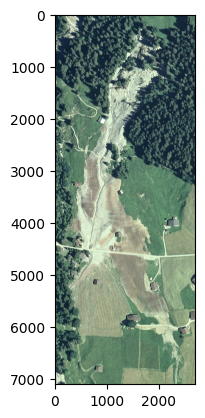

In [3]:
img = Image.open(src_img)
img_arr = np.array(img)
plt.imshow(img_arr)

#### Predictions making

In [4]:
if not os.path.dirname(os.getcwd()) in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))
from inference import run_inference, predict_image
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation


def mirror_pad_image(img, tile_size, stride):
    """
    img: (H, W, C)
    """
    H, W = img.shape[:2]

    pad_h = (stride - (H - tile_size) % stride) % stride
    pad_w = (stride - (W - tile_size) % stride) % stride

    padded = np.pad(
        img,
        ((0, pad_h),
         (0, pad_w),
         (0, 0)),
        mode="reflect"
    )

    return padded, (pad_h, pad_w), (H, W)


def load_latest_checkpoint(model_dir):
    """
    Returns the path to the latest checkpoint folder inside model_dir.
    If none found, return model_dir (trained_model directory).
    """
    if not os.path.isdir(model_dir):
        raise ValueError(f"Model directory not found: {model_dir}")

    ckpts = [d for d in os.listdir(model_dir) if d.startswith("checkpoint-")]
    if not ckpts:
        print("[INFO] No checkpoints found. Using main model directory.")
        return model_dir

    # Sort by step number
    ckpts_sorted = sorted(ckpts, key=lambda x: int(x.split("-")[1]))
    last_ckpt = ckpts_sorted[-1]

    print(f"[INFO] Using checkpoint: {last_ckpt}")
    return os.path.join(model_dir, last_ckpt)


def gaussian_weight(size, sigma=0.125):
    ax = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(ax, ax)
    return np.exp(-(xx**2 + yy**2) / (2 * sigma**2))


def predict(image, model_dir, img_path=None, tile_size=512, stride=256, th=0.5, do_show=True, do_save=True, do_save_mask_as_img=True):
    if not isinstance(image, Image.Image):
        img_path = image
        image = Image.open(image)
    img_arr = np.array(image)

    img_padded, _, _ = mirror_pad_image(img_arr, tile_size, stride)
    H_original, W_original  = img_arr.shape[:2]
    H, W = img_padded.shape[:2]
    
    # prepare arrays
    prob_acc = np.zeros((H,W), dtype=np.float32)
    weight_acc = np.zeros((H,W), dtype=np.float32)
    weights = gaussian_weight(tile_size)

    # load model
    ckpt_path = load_latest_checkpoint(model_dir)
    processor = AutoImageProcessor.from_pretrained(ckpt_path)
    model = SegformerForSemanticSegmentation.from_pretrained(ckpt_path)
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(DEVICE)
    model.eval()

    for x in range(0, W - tile_size + 1, stride):# manage if borders reached
        for y in range(0, H - tile_size + 1, stride):
            x0 = min(x, W - tile_size)
            y0 = min(y, H - tile_size)

            # Crop region (handles border tiles automatically)
            tile = img_padded[y0:y0 + tile_size, x0:x0 + tile_size, :]
            tile_PIL = Image.fromarray(tile).convert("RGB")
            _, logits  = predict_image(model, processor, tile_PIL, DEVICE)

            prob = torch.softmax(logits, dim=1).cpu().numpy()
            landslide_prob = prob[:, 1].reshape((tile_size, tile_size))

            # prob_acc[y:y+tile_size, x:x+tile_size] += landslide_prob * weights
            # weight_acc[y:y+tile_size, x:x+tile_size] += weights
            prob_acc[y0:y0+tile_size, x0:x0+tile_size] += landslide_prob
            weight_acc[y0:y0+tile_size, x0:x0+tile_size] += 1

    full_prob = prob_acc / np.maximum(weight_acc, 1e-6)
    final_prob = full_prob[0:H_original, 0:W_original]
    
    final_labels = np.zeros(final_prob.shape)
    final_labels[final_prob >= th] = 1

    src_dest_preds_mask = os.path.splitext(img_path)[0] + '_preds_mask.tif'
    src_dest_preds_img = os.path.splitext(img_path)[0] + '_preds_img.tif'

    rgb_labels = np.zeros((final_labels.shape[0], final_labels.shape[1], 3))
    rgb_labels[final_labels == 1] = 255
    if do_save:
        Image.fromarray(final_labels.astype(np.uint8)).save(src_dest_preds_mask)
        if do_save_mask_as_img:
            Image.fromarray(rgb_labels.astype(np.uint8)).save(src_dest_preds_img)
    
    if do_show:
        plt.imshow(Image.fromarray(rgb_labels.astype(np.uint8)))

    return final_labels, rgb_labels, final_prob


d:\GitHubProjects\Terranum_repo\LandSlides\segformerlandslides\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Predictions at different resolutions

In [5]:
# Utils
def produce_with_lower_res(src_img, res_frac, do_save=True, do_show=True):
    img = Image.open(src_img)
    res_original = img.size
    low_res = tuple([int(x * res_frac) for x in res_original])

    img_low = img.resize((low_res), resample=Image.BILINEAR)
    src_dest = os.path.splitext(src_img)[0] + f'_res_{res_frac}.tif'
    if do_save:
        img_low.save(src_dest)
    if do_show:
        plt.imshow(img_low)
    
    return img_low, src_dest

(<PIL.Image.Image image mode=RGBA size=27x71>,
 'D:\\GitHubProjects\\Terranum_repo\\LandSlides\\segformerlandslides\\data\\test_multi_resolution\\1999_56\\image_1999_56_res_0.01.tif')

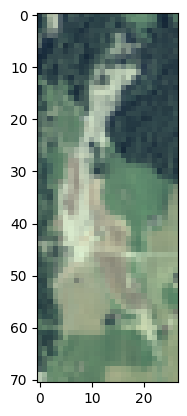

In [6]:
produce_with_lower_res(src_img, 0.01)

In [7]:
images = []
preds = []
masks = []
probas = []
for _, res in tqdm(enumerate(RESOLUTIONS), total=len(RESOLUTIONS)):
    res_img, src_res_img = produce_with_lower_res(src_img, res, do_show=False)
    pred_mask, preds_img, proba_img = predict(res_img, img_path=src_res_img, model_dir=MODEL_DIR, th=THRESHOLD, do_show=False)
    images.append(res_img)
    preds.append(preds_img)
    masks.append(pred_mask)
    probas.append(proba_img)


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Using checkpoint: checkpoint-14100


 20%|██        | 1/5 [00:07<00:28,  7.05s/it]

[INFO] Using checkpoint: checkpoint-14100


 40%|████      | 2/5 [00:10<00:15,  5.12s/it]

[INFO] Using checkpoint: checkpoint-14100


 60%|██████    | 3/5 [00:12<00:07,  3.72s/it]

[INFO] Using checkpoint: checkpoint-14100


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

[INFO] Using checkpoint: checkpoint-14100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


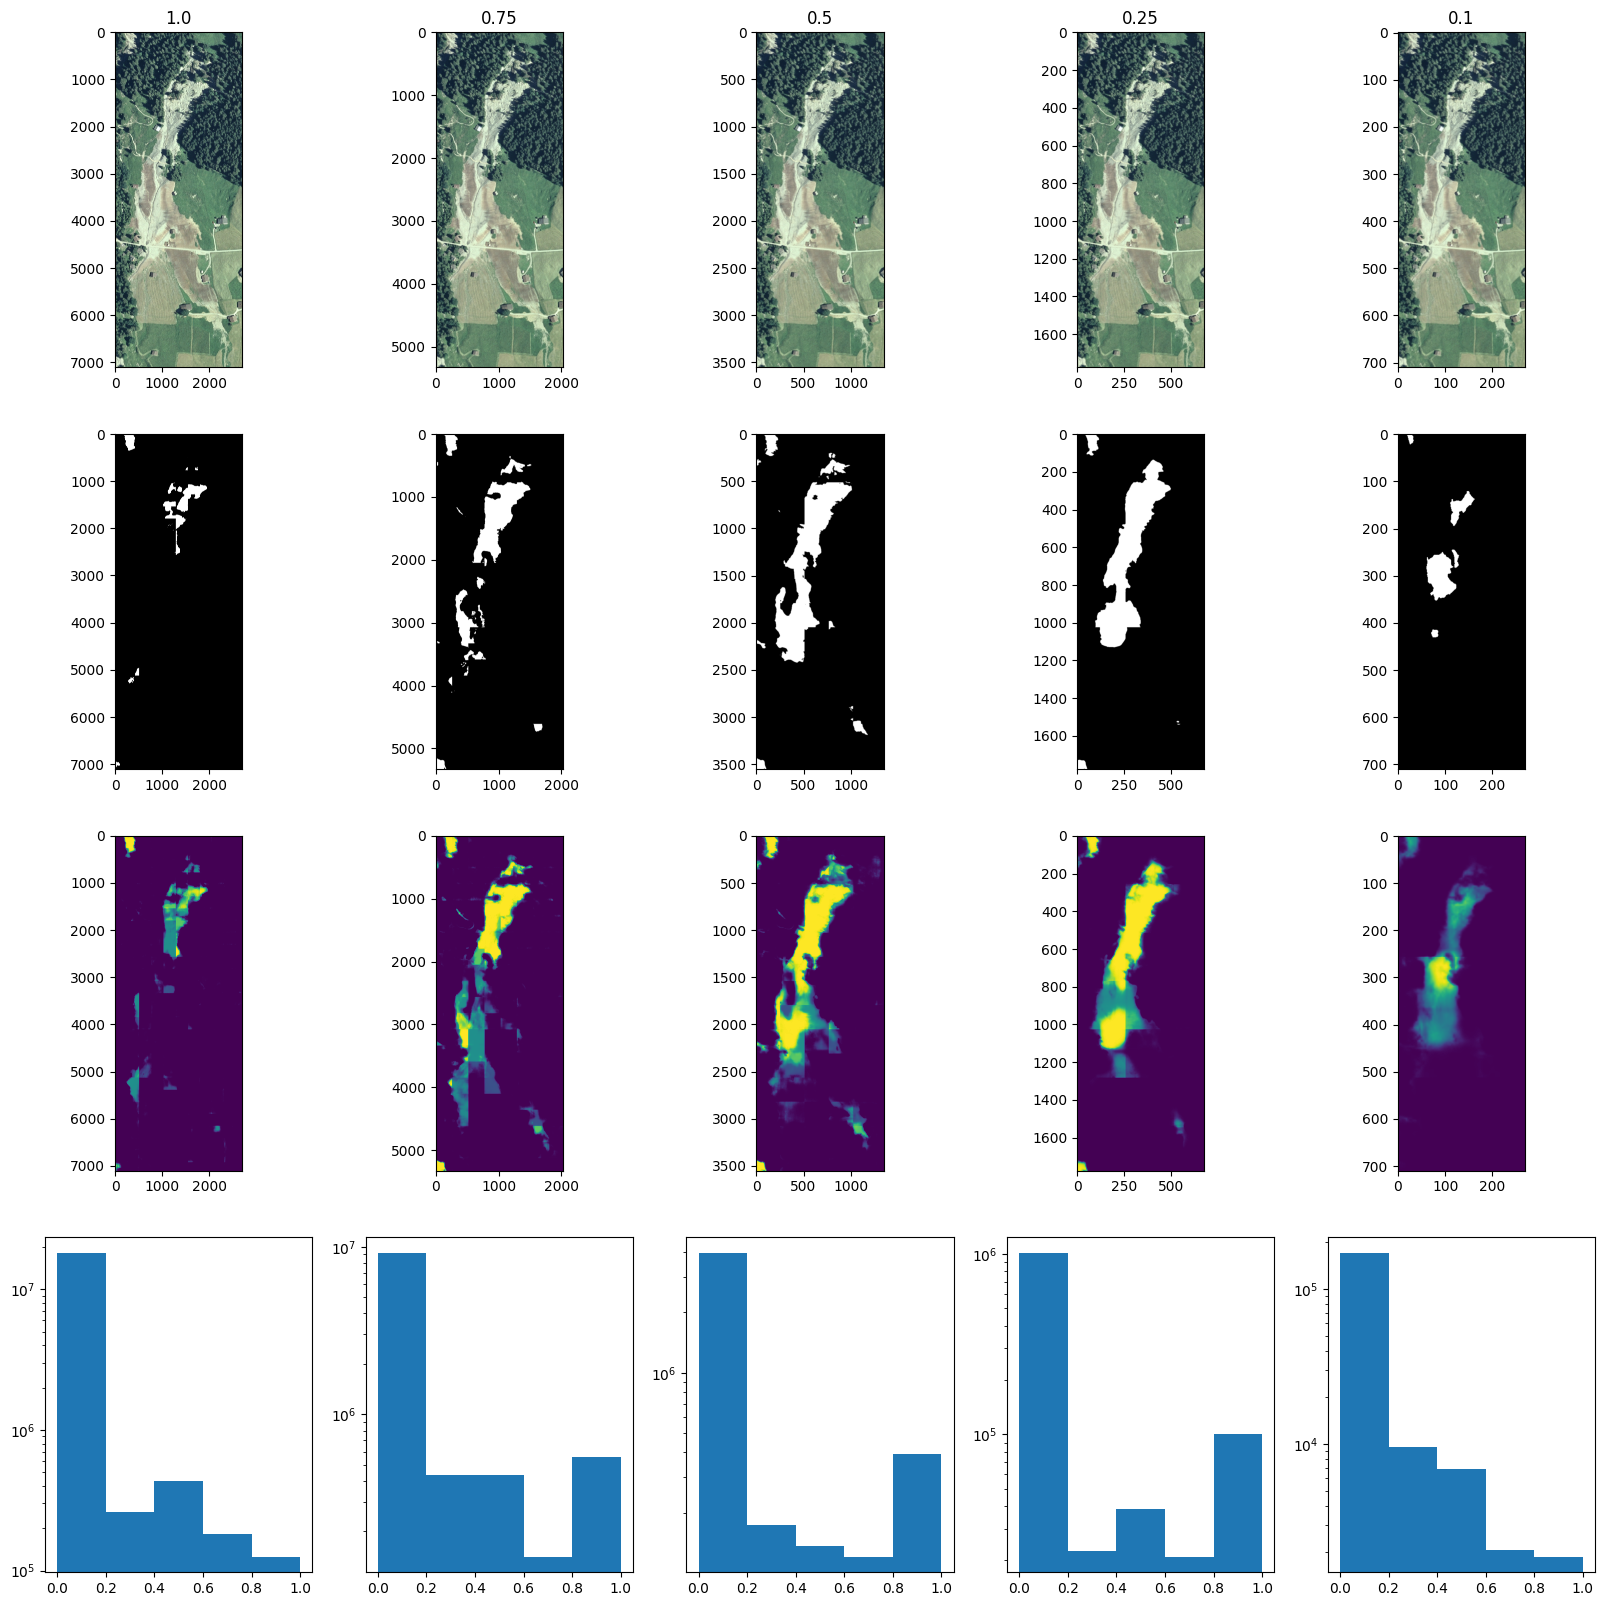

In [ ]:
dims = preds[0].shape[:2]
fig, axs = plt.subplots(4, len(images), figsize=((4*len(images), 20)))
for i in range(len(images)):
    axs[0,i].imshow(np.array(images[i]))
    axs[1,i].imshow(preds[i])
    axs[2,i].imshow(probas[i])
    axs[0,i].set_title(RESOLUTIONS[i])
    axs[3,i].hist(probas[i].flatten(), bins=5, range=[0.0, 1.0], log=True)

#### Merge different resolutions into one

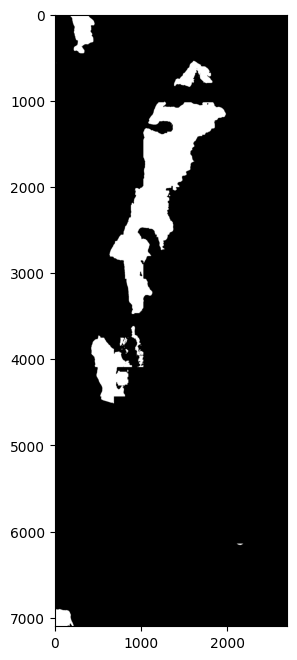

In [ ]:
original_img = Image.open(src_img)
do_save = True
do_show = True
THRESHOLD = 0.5
W, H = original_img.size

final_product = np.zeros((H, W), dtype=np.float32)

for mask in masks:
    rescaled_mask = Image.fromarray(mask).resize((W, H), Image.NEAREST)
    final_product += rescaled_mask

final_product /= len(masks)
final_product[final_product >= THRESHOLD] = 1
final_product[final_product < THRESHOLD] = 0
final_product = final_product.astype(np.uint8)

final_product_rgb = np.zeros((final_product.shape[0], final_product.shape[1], 3))
final_product_rgb[final_product == 1] = 255

src_final_mask = os.path.splitext(src_img)[0] + "_final_prod_mask.tif"
src_final_img = os.path.splitext(src_img)[0] + "_final_prod_image.tif"
if do_save:
    Image.fromarray(final_product.astype(np.uint8)).save(src_final_mask)
    Image.fromarray(final_product_rgb.astype(np.uint8)).save(src_final_img)

if do_show:
    plt.figure(figsize=(3,9))
    plt.imshow(Image.fromarray(final_product_rgb.astype(np.uint8)))


#### Show prob heatmap

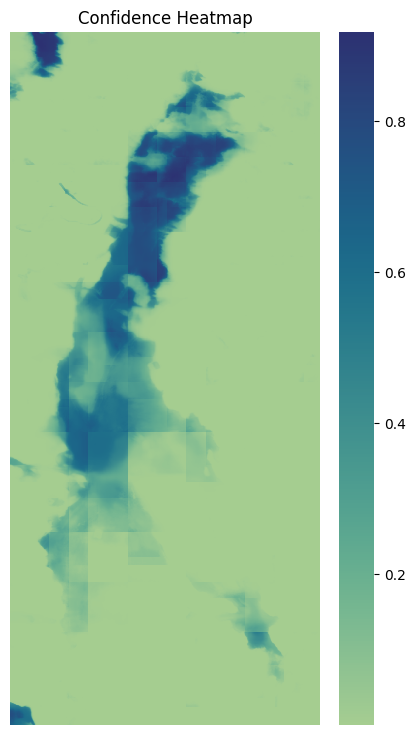

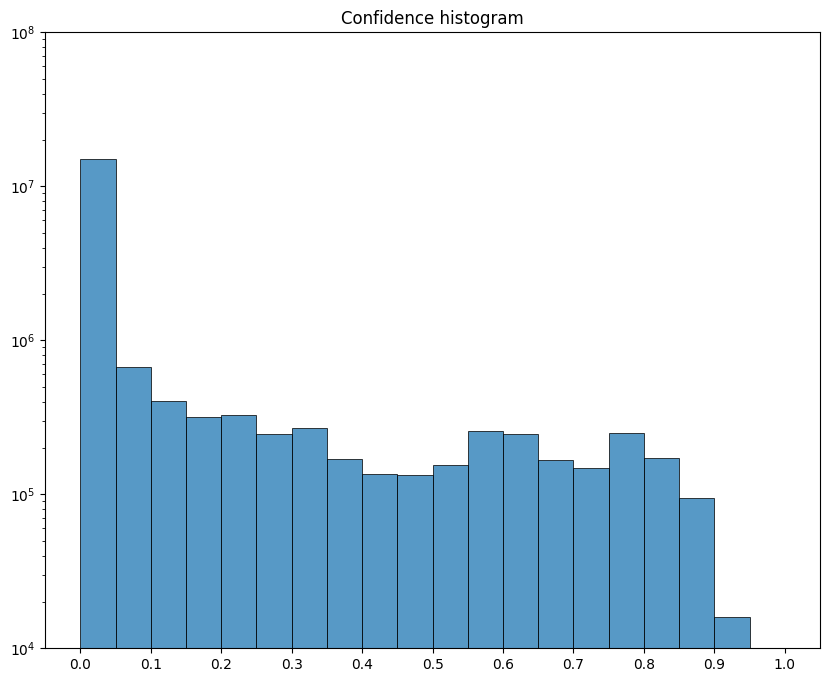

In [79]:
original_img = Image.open(src_img)
do_save = True
do_show = True
THRESHOLD = 0.5
W, H = original_img.size

final_product = np.zeros((H, W), dtype=np.float32)

for proba in probas:
    rescaled_mask = Image.fromarray(proba).resize((W, H), Image.NEAREST)
    final_product += rescaled_mask

final_product /= len(probas)

# plot heatmap
fig = plt.figure(figsize=(5,9))
sns.heatmap(final_product, cmap='crest')
plt.axis('off')
plt.title('Confidence Heatmap')
if do_show:
    plt.show()
if do_save:
    src_final_proba = os.path.splitext(src_img)[0] + "_final_prod_proba.tif"
    fig.savefig(src_final_proba)
plt.close()

# plot histogram
fig = plt.figure(figsize=(10,8))
plt.hist(
    final_product.flatten(),
    bins=20,
    range=[0.0, 1.0],
    log=True,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.75
)
plt.xticks(np.arange(0.0,1.1,0.1))
plt.yticks(np.logspace(4, 8, 5))
plt.title('Confidence histogram')
if do_show:
    plt.show()
if do_save:
    src_final_hist = os.path.splitext(src_img)[0] + "_final_prod_proba_hist.tif"
    plt.draw()
    fig.savefig(src_final_hist)
plt.close()